# Árboles de decisión

Los árboles de decisión se basan en una separación del espacio de atributos (features) que implique la separación de muestras de distintos grupos. De este modo, son muy adaptables cubriendo relaciones lineales como no-lineales entre las variables disponibles y la variable objetivo que persigamos.

![tree](./img/tree.png)

## CART

Es uno de los algoritmos más extendido, derivado de C4.5 y sucesor de [ID3](https://es.wikipedia.org/wiki/Algoritmo_ID3). Es empleado en labores de clasificación como de regresión, donde el resultado numérico se establece mediante el promediado de las muestras en un nodo terminal.

El árbol se divide en un **nodo raíz** que comprende el primer **nodo de decisión**. Toma un atributo buscando una separación entre las clases objetivo de manera que existan el menor número de elementos de una clase dada la otra. Así, conseguimos ir separando elementos hasta llegar a los **nodos terminales** donde idealmente solo dispondremos de muestras de un único tipo, siendo los nodos de decisión anteriores el camino para determinar cómo se establece la decisión del nodo terminal.

¿Cuando acaba? Bien cuando todo queda perfectamente acotado (nunca suele suceder) o bien cuando lleguemos a un nivel máximo de profundidad. La profundidad del árbol nos permite acotar el sobreajuste del modelo.

El empleo para clasificación o regresión depende en el criterio de separación. La impureza es el criterio perseguido en clasificación mientras que en regresión nos centraremos en métricas continuas como el error cuadrático promedio (MSE).

### Criterio de decisión

* **Gini**: Establece un nivel de impureza en un nodo dado. https://es.wikipedia.org/wiki/Coeficiente_de_Gini
* **Entropía**: Mide el nivel de orden o de capacidad informativa de un sistema: https://es.wikipedia.org/wiki/Entrop%C3%ADa

Tomando esto como referencia, el algoritmo decide en base a estos criterios el mejor corte para un atributo dado.

![treeiris](./img/treeiris.png)

Se conocen como modelos **white box** dado que la decisión tomada es muy comprensible por un humano simplemente siguiendo la lógica de corte del árbol. Esto se vuelve más complejo según el árbol se hace más grande pero aún así resulta más entendible que otros modelos conocidos como **black box**.

Probemos cómo sería con nuestros datos del problema Iris.

In [141]:
from sklearn.datasets import load_iris

iris = load_iris(as_frame=True)

X = iris.data
y = iris.target

X.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


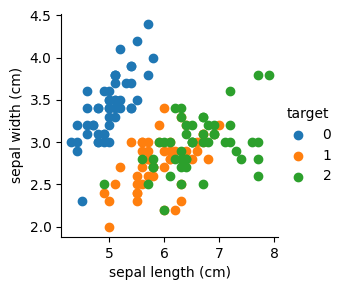

In [142]:
import seaborn as sns
import matplotlib.pyplot as plt

df = X.copy()
df['target'] = y

sns.FacetGrid(df, hue='target')\
.map(plt.scatter,'sepal length (cm)','sepal width (cm)')\
.add_legend();

In [143]:
features = ['sepal length (cm)','sepal width (cm)']

X_train = X[features]

In [144]:
from sklearn.linear_model import LogisticRegression

lgreg = LogisticRegression(max_iter=10000)
lgreg.fit(X_train,y)

lgreg.score(X_train,y)

0.82

In [151]:
from sklearn.tree import DecisionTreeClassifier

tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train, y)

tree_clf.score(X_train,y)

0.9266666666666666

In [152]:
tree_clf.get_depth()

12

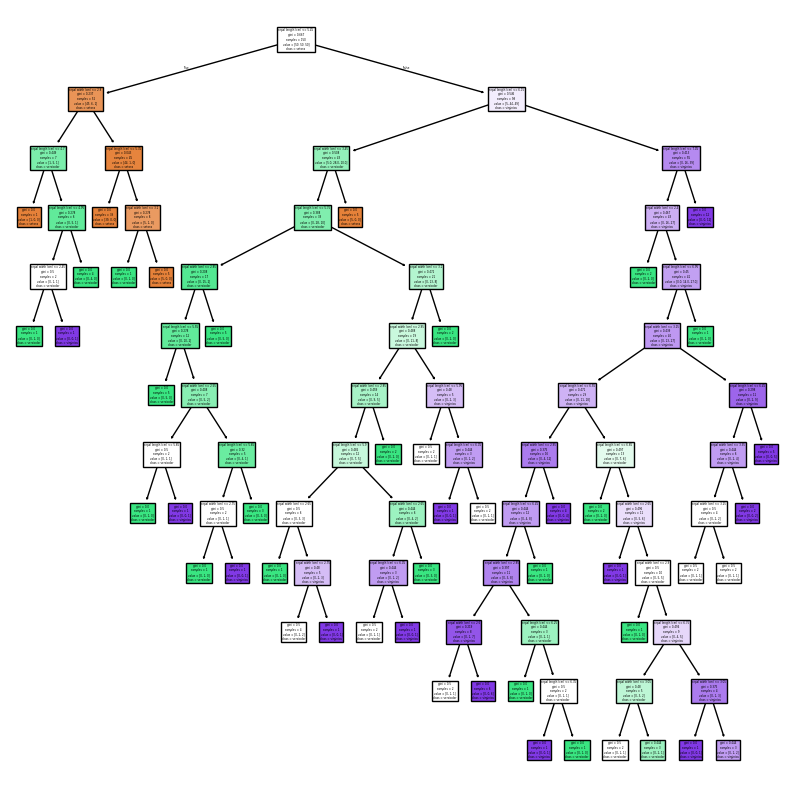

In [153]:
from sklearn.tree import plot_tree

plt.figure(figsize=(10,10))

plot_tree(tree_clf,
               feature_names=iris.feature_names,
               class_names=iris.target_names,
               filled = True);

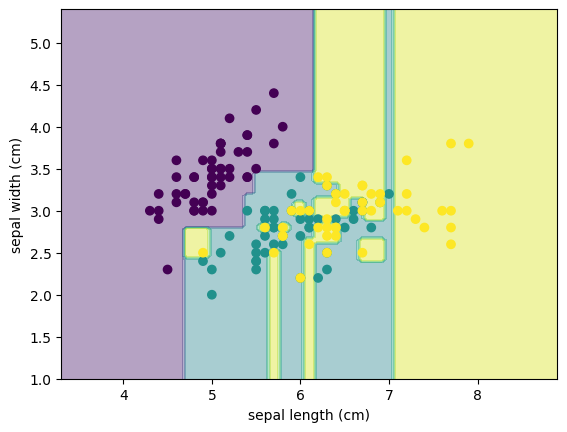

In [154]:
from sklearn.inspection import DecisionBoundaryDisplay

DecisionBoundaryDisplay.from_estimator(
        tree_clf, X_train, alpha=0.4, response_method="predict"
    )
plt.scatter(X_train.iloc[:,0], X_train.iloc[:,1], c=y);

Podemos ver cómo de relevantes, importantes, son las variables seleccionadas.

In [155]:
list(zip(tree_clf.feature_importances_, tree_clf.feature_names_in_))

[(np.float64(0.6674054652284368), 'sepal length (cm)'),
 (np.float64(0.3325945347715632), 'sepal width (cm)')]

En este caso vemos que la longitud del sépalo es mucho más relevante para la tarea en cuestión, lo cual justifica que resulte en el primer punto de corte del árbol arriba representado. Podemos jugar con la poda del árbol para ver si cambia en algo la precisión del mismo.

In [156]:
# Variad la profundidad del árbol
depth = 2

tree_clf = DecisionTreeClassifier(max_depth=depth,
                                  random_state=42)
tree_clf.fit(X_train, y)

tree_clf.score(X_train,y)

0.7733333333333333

In [159]:
list(zip(tree_clf.feature_importances_, tree_clf.feature_names_in_))

[(np.float64(0.8560534166130993), 'sepal length (cm)'),
 (np.float64(0.14394658338690072), 'sepal width (cm)')]

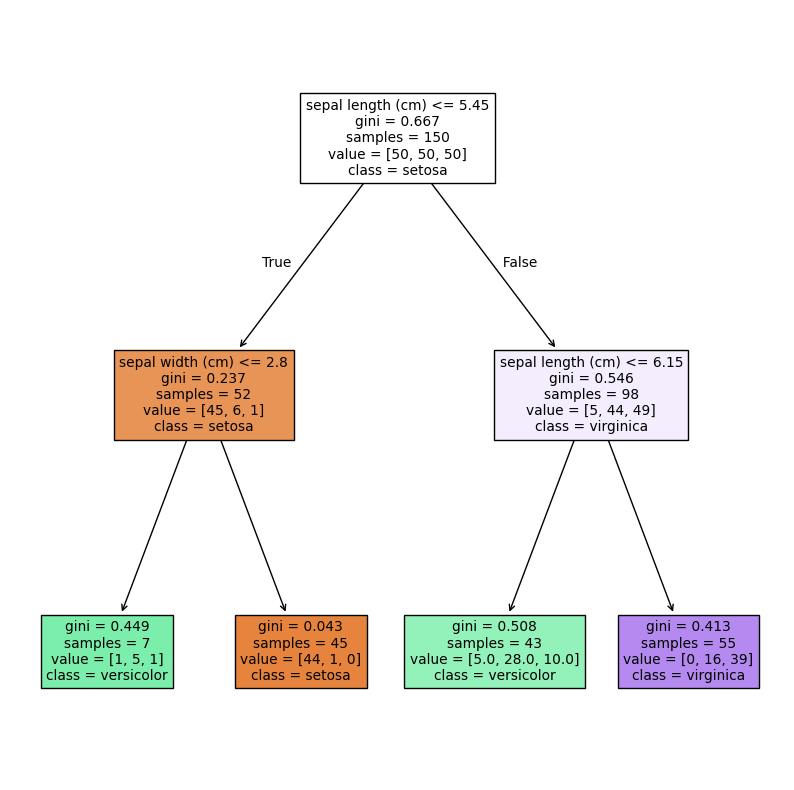

In [157]:
plt.figure(figsize=(10,10))

plot_tree(tree_clf,
               feature_names=iris.feature_names,
               class_names=iris.target_names,
               filled = True);

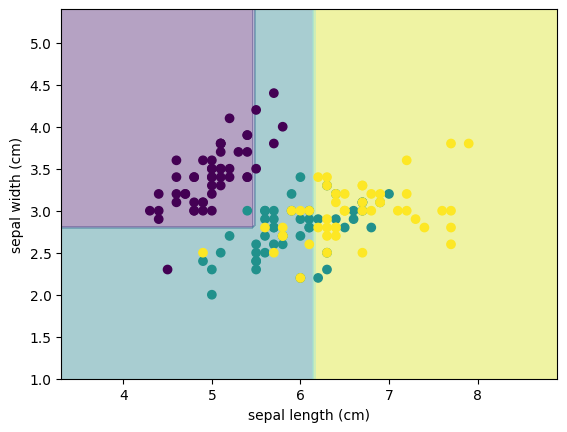

In [158]:
DecisionBoundaryDisplay.from_estimator(
        tree_clf, X_train, alpha=0.4, response_method="predict"
    )
plt.scatter(X_train.iloc[:,0], X_train.iloc[:,1], c=y);

Predicciones y probabilidad asociada.

In [77]:
indice = 60

muestra = X_train[(indice-1):indice]
muestra

,sepal length (cm),sepal width (cm)
59,5.2,2.7


In [78]:
y[indice]

np.int64(1)

In [79]:
tree_clf.predict_proba(X_train[2:3])

array([[1., 0., 0.]])

In [80]:
tree_clf.predict(X_train[2:3])

array([0])

# Sensibilidad al entrenamiento

Los árboles de decisión son muy sensibles a pequeñas variaciones en los datos de muestra. Por ejemplo, si eliminamos los elementos más extremos de la categoría Versicolor mirad lo que sucede.

In [114]:
X[(X[:, 1]==X[:, 1][y==1].max()) & (y==1)] # el Iris versicolor más ancho

array([[4.8, 1.8]])

In [115]:
not_widest_versicolor = (X[:, 1]!=1.8) | (y==2)
X_tweaked = X[not_widest_versicolor]
y_tweaked = y[not_widest_versicolor]

tree_clf_tweaked = DecisionTreeClassifier(max_depth=2, random_state=40)
tree_clf_tweaked.fit(X_tweaked, y_tweaked)

DecisionTreeClassifier(max_depth=2, random_state=40)

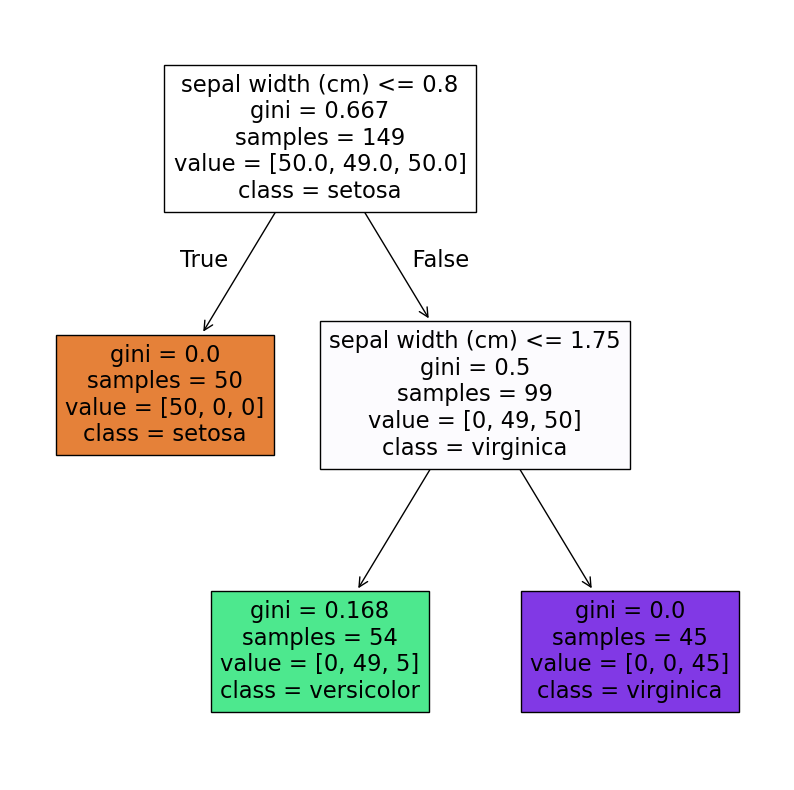

In [116]:
plt.figure(figsize=(10,10))

plot_tree(tree_clf_tweaked,
               feature_names=iris.feature_names,
               class_names=iris.target_names,
               filled = True);

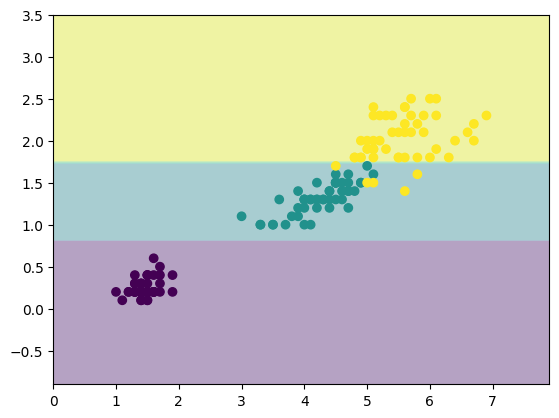

In [117]:
DecisionBoundaryDisplay.from_estimator(
        tree_clf_tweaked, X_tweaked, alpha=0.4, response_method="predict"
    )
plt.scatter(X_tweaked[:,0], X_tweaked[:,1], c=y_tweaked);

Podemos ver que también afectan mucho los parámetros que empleemos para determinar el corte del árbol en los nodos terminales. Si por ejemplo decimos que cuatro elementos serán los mínimos necesarios para considerar un nodo terminal bueno.

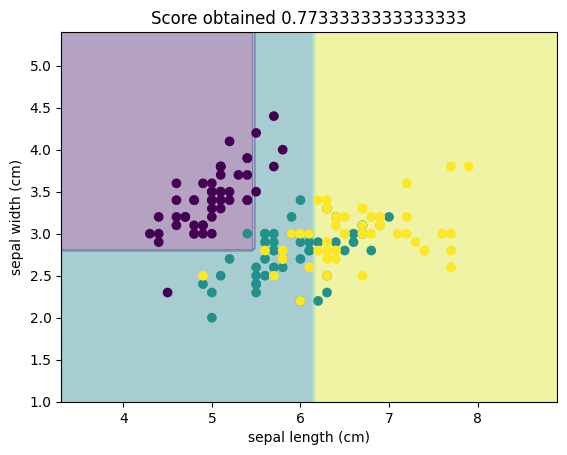

In [125]:
tree_clf = DecisionTreeClassifier(max_depth=2, random_state=40, min_samples_leaf=4)
tree_clf.fit(X_train, y)

DecisionBoundaryDisplay.from_estimator(
        tree_clf, X_train, alpha=0.4, response_method="predict"
    )
plt.scatter(X_train.iloc[:,0], X_train.iloc[:,1], c=y)
plt.title(f"Score obtained {tree_clf.score(X_train, y)}");

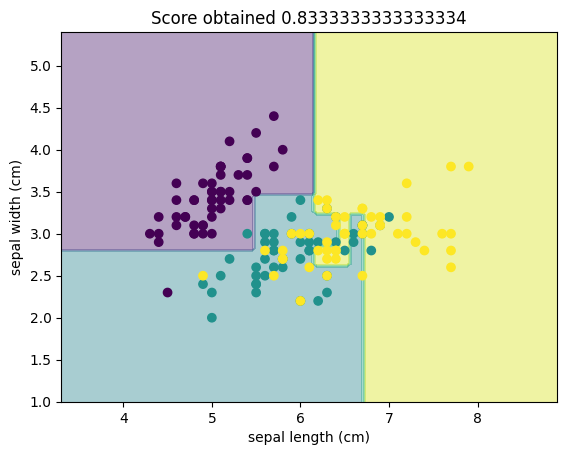

In [126]:
tree_clf = DecisionTreeClassifier(max_depth=12, random_state=40, min_samples_leaf=4)
tree_clf.fit(X_train, y)

DecisionBoundaryDisplay.from_estimator(
        tree_clf, X_train, alpha=0.4, response_method="predict"
    )
plt.scatter(X_train.iloc[:,0], X_train.iloc[:,1], c=y)
plt.title(f"Score obtained {tree_clf.score(X_train, y)}");

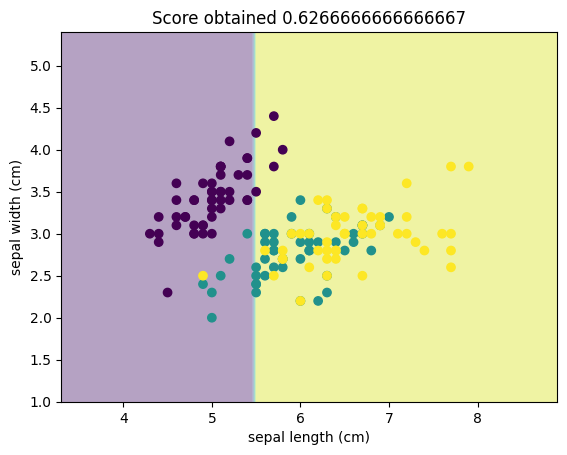

In [130]:
tree_clf = DecisionTreeClassifier(max_depth=12, random_state=40, min_samples_leaf=50)
tree_clf.fit(X_train, y)

DecisionBoundaryDisplay.from_estimator(
        tree_clf, X_train, alpha=0.4, response_method="predict"
    )
plt.scatter(X_train.iloc[:,0], X_train.iloc[:,1], c=y)
plt.title(f"Score obtained {tree_clf.score(X_train, y)}");

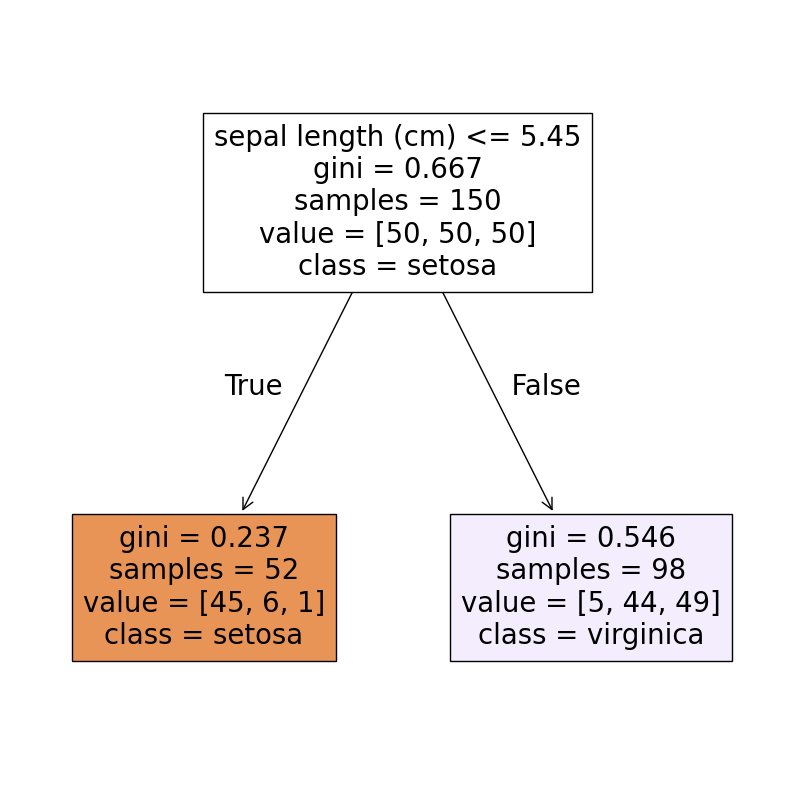

In [131]:
plt.figure(figsize=(10,10))

plot_tree(tree_clf,
               feature_names=iris.feature_names,
               class_names=iris.target_names,
               filled = True);

# Regression trees

Podemos emplear este mismo modelo en su modalidad de regresión.

In [134]:
import numpy as np

# Quadratic training set + noise
np.random.seed(42)

m = 200
X = np.random.rand(m, 1)

# 4(x-1/2)^2
y = 4 * (X - 0.5) ** 2
y = y + np.random.randn(m, 1) / 10

In [135]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg.fit(X, y)

DecisionTreeRegressor(max_depth=2, random_state=42)

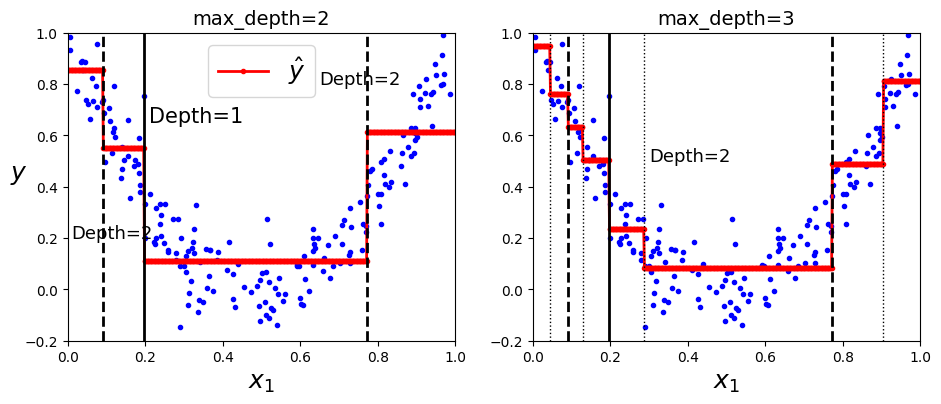

In [136]:
from sklearn.tree import DecisionTreeRegressor

tree_reg1 = DecisionTreeRegressor(random_state=42, max_depth=2)
tree_reg2 = DecisionTreeRegressor(random_state=42, max_depth=3)
tree_reg1.fit(X, y)
tree_reg2.fit(X, y)

def plot_regression_predictions(tree_reg, X, y, axes=[0, 1, -0.2, 1], ylabel="$y$"):
    x1 = np.linspace(axes[0], axes[1], 500).reshape(-1, 1)
    y_pred = tree_reg.predict(x1)
    plt.axis(axes)
    plt.xlabel("$x_1$", fontsize=18)
    if ylabel:
        plt.ylabel(ylabel, fontsize=18, rotation=0)
    plt.plot(X, y, "b.")
    plt.plot(x1, y_pred, "r.-", linewidth=2, label=r"$\hat{y}$")

plt.figure(figsize=(11, 4))
plt.subplot(121)
plot_regression_predictions(tree_reg1, X, y)
for split, style in ((0.1973, "k-"), (0.0917, "k--"), (0.7718, "k--")):
    plt.plot([split, split], [-0.2, 1], style, linewidth=2)
plt.text(0.21, 0.65, "Depth=1", fontsize=15)
plt.text(0.01, 0.2, "Depth=2", fontsize=13)
plt.text(0.65, 0.8, "Depth=2", fontsize=13)
plt.legend(loc="upper center", fontsize=18)
plt.title("max_depth=2", fontsize=14)

plt.subplot(122)
plot_regression_predictions(tree_reg2, X, y, ylabel=None)
for split, style in ((0.1973, "k-"), (0.0917, "k--"), (0.7718, "k--")):
    plt.plot([split, split], [-0.2, 1], style, linewidth=2)
for split in (0.0458, 0.1298, 0.2873, 0.9040):
    plt.plot([split, split], [-0.2, 1], "k:", linewidth=1)
plt.text(0.3, 0.5, "Depth=2", fontsize=13)
plt.title("max_depth=3", fontsize=14)
plt.show()

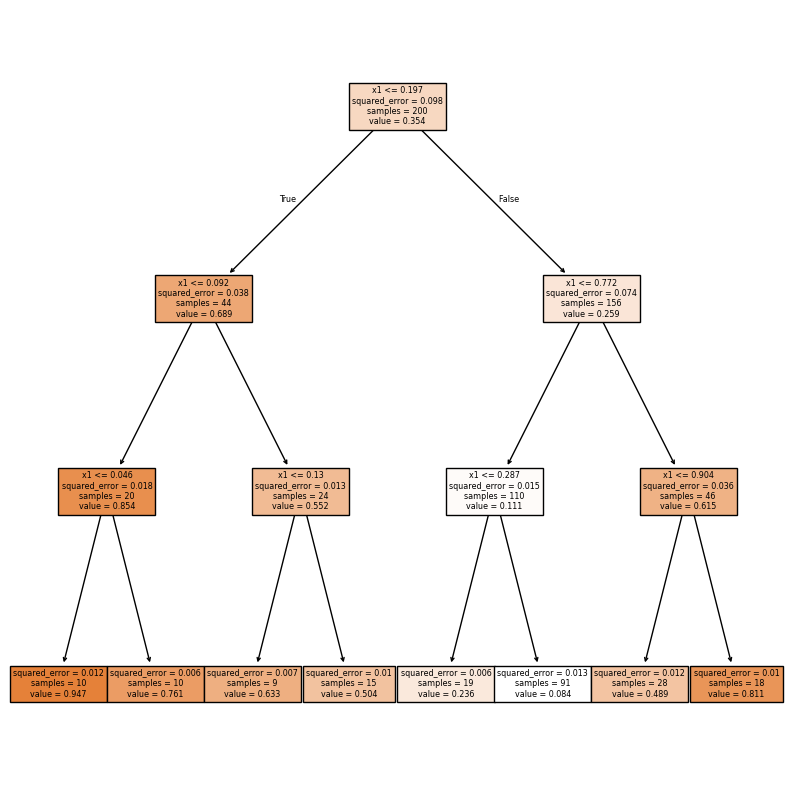

In [137]:
plt.figure(figsize=(10,10))

plot_tree(tree_reg2,
               feature_names=["x1"],
               class_names=iris.target_names,
               filled = True);

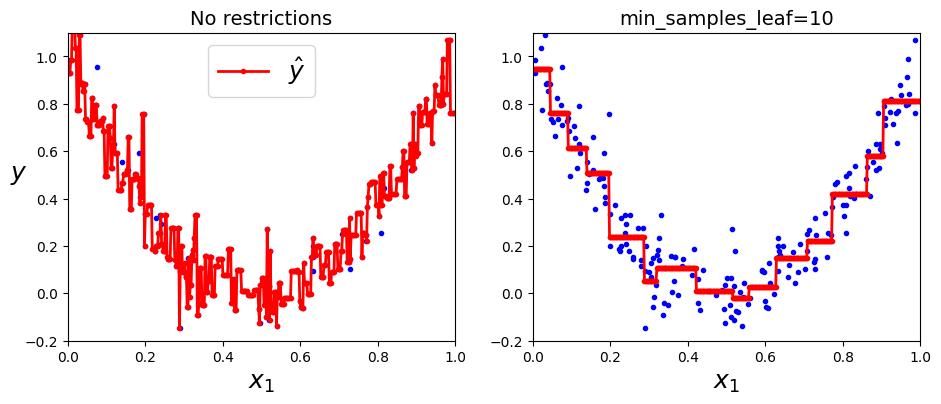

In [138]:
tree_reg1 = DecisionTreeRegressor(random_state=42)
tree_reg2 = DecisionTreeRegressor(random_state=42, min_samples_leaf=10)
tree_reg1.fit(X, y)
tree_reg2.fit(X, y)

x1 = np.linspace(0, 1, 500).reshape(-1, 1)
y_pred1 = tree_reg1.predict(x1)
y_pred2 = tree_reg2.predict(x1)

plt.figure(figsize=(11, 4))

plt.subplot(121)
plt.plot(X, y, "b.")
plt.plot(x1, y_pred1, "r.-", linewidth=2, label=r"$\hat{y}$")
plt.axis([0, 1, -0.2, 1.1])
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", fontsize=18, rotation=0)
plt.legend(loc="upper center", fontsize=18)
plt.title("No restrictions", fontsize=14)

plt.subplot(122)
plt.plot(X, y, "b.")
plt.plot(x1, y_pred2, "r.-", linewidth=2, label=r"$\hat{y}$")
plt.axis([0, 1, -0.2, 1.1])
plt.xlabel("$x_1$", fontsize=18)
plt.title("min_samples_leaf={}".format(tree_reg2.min_samples_leaf), fontsize=14)

plt.show();

**Ventajas**

* Computacionalmente son eficientes
* Requiere muy poco preprocesado (no hace falta estandarizar ni normalizar valores)
* Son robustos frente a outliers.
* Resistentes a variables irrelevantes.
* Si son cortos, son muy sencillos de explicar e interpretables. Manejan un solo parámetro (tree size). 
* Se pueden visualizar y de forma muy intuitiva.
* Se puede usar con pocos o muchos datos de entrenamiento.

**Desventajas**

* No es muy preciso.
* Inestabilidad. Muy sensible a pequeñas variaciones en los datos de entrenamiento.
* Muy propenso al sobreajuste si no se controla el tamaño del árbol.
* Arboles grandes son difíciles de interpretar.
* Cada split depende del anterior, por lo que los errores cometidos se propagan.

Referencias:

* http://www.r2d3.us/una-introduccion-visual-al-machine-learning-1/